In [1]:
import pyLCR
import os
import urllib
import json
import numpy as np
import io
import sys
import math
from statistics import mode

import astropy
from astropy.table import Table, Column
from astropy.time import Time
from astropy.io import fits
import pandas as pd
import array as arr

from pyLCR.DataTools import getLightCurve
from pyLCR.PlottingTools import plotLightCurve
from pyLCR.PlottingTools import computeDate
from pyLCR.PlottingTools import getCurrentMET
from pyLCR.PlottingTools import computeMJD
from pyLCR.Sources import sources

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from astropy.stats import bayesian_blocks
import qb
import hop


The Fermi-LAT Light Curve Repository Toolkit v0.1.0
Support Contact: Daniel Kocevski (daniel.kocevski@nasa.gov)


In [2]:
def filter_data(n):
    '''
    This is the same exact function that you have, that we made together!
    '''
    #creat list inside dictionary
    list_of_bad_indexes[n] = np.array([], dtype=int)
    

    #print(type(n))#make sure data is being read as str
    #check if the sourse contains data
    data = pyLCR.getLightCurve(n, cadence='daily', flux_type='photon', index_type='fixed', ts_min=1)
    if data is None:
        return()  
    else:
      # Access and print the 'flux_error' attribute if data is not None
        if hasattr(data, 'flux_error'):
            data.ts = data.ts[data.ts >= 1]
            print (len(data.flux))
            bad_ids = np.where(data.flux >= 1e-4)[0]#first filter for if a source is too bright
            list_of_bad_indexes[n]= np.append(list_of_bad_indexes[n],bad_ids)#append the too bright indexes to our bad indexes
            
     
            for t in range(1, len(data.met_detections)-1):#nested loop with reference to time
                if t in list_of_bad_indexes[n]:
                    pass
               
                elif (data.flux[t]/(data.flux_error[t][1]-data.flux[t]))**2 > 300*data.ts[t]:#find outliars
                     list_of_bad_indexes[n]= np.append(list_of_bad_indexes[n],t)#add to bad list
                elif (data.flux[t]/(data.flux_error[t][0]-data.flux[t]))**2 > 300*data.ts[t]:
                     list_of_bad_indexes[n]= np.append(list_of_bad_indexes[n],t)
                    
              
            
            
            
            #make data type bool where bad indexes is false  
            mask = np.ones(len(data.flux), dtype=bool)
            mask[list_of_bad_indexes[n]] = False #make them hidden
            print('Number of bad indexes:')
            print(len(list_of_bad_indexes[n]))
            #make 'good' data what is left when bad inexes are masked
            good_flux[n]= data.flux[mask]
            good_errs[n]= data.flux_error[mask]
            good_dets[n]=convert_mjds(data.met_detections[mask])
            list_of_good_names.append(str(n))
            #print('Number of good flux bins:')
            #print (len(good_flux[n]))
        else:
            return()

        return()  


def convert_mjds(mets):
    '''
    Same as before!
    '''
    met_start=239889601 #start of survey in secs
    mjd_start=54686.5 #start in days
    mjd_values=((mets-met_start)/86400)+mjd_start #conversion
    return (mjd_values)#days not seconds 

In [3]:
'''
I have just renamed new_flares into strong_flares so we remember what this list is.

If we want to filter, block, and plot this data later, we can just do
'for n (or name, or source, or s, whatever we want to name it) in strong_flares:',
instead of renaming the variable 'names', since that has caused some issues, lol!
'''

strong_flares=np.array(['4FGL J0222.6+4302',
                        '4FGL J0538.8-4405',
                        '4FGL J0725.2+1425',
                        '4FGL J1146.9+3958',
                        '4FGL J1159.5+2914',
                        '4FGL J1229.0+0202',
                        '4FGL J1239.5+0443',
                        '4FGL J1345.5+4453',
                        '4FGL J1427.0+2348',
                        '4FGL J1427.6-3305',
                        '4FGL J1625.7-2527',
                        '4FGL J1626.0-2950',
                        '4FGL J2232.6+1143',
                        '4FGL J2253.9+1609'])

In [4]:
def block_good_fluxes(times, fluxes, errors):
    '''
    Below I have replaced every instance of a specific named variable, 
    like good_dets, with instead the arbitrary variable name that we 
    used when defining the function.
    
    This means that if someone else wanted to use the code, 
    they would be able to better understand that they need to 
    give the function an array of times, fluxes, and errors 
    - they can be named whatever they want to be named outside
    of the function, but this way it is easier to read what 
    content of the each given array should contain (e.g. 
    whatever you name your times array, it should still have an array of times).
        
    This makes the code generalizable, easier to read, and you would use it
    by calling the function and passing it your real, named arrays,
    like good_dets[n], when you use the function later.
    '''
    edges = bayesian_blocks(times, fluxes, sigma=(errors.max(axis=1)-fluxes),fitness='measures')
    #edges = bayesian_blocks(good_dets[name], good_flux[name], sigma=(good_errs[name].max(axis=1)-good_flux[name]),fitness='measures')
    blocked_flux = []
    blocked_errs = []
    blocked_edges = []
    try:
        quiescent_baseline = np.median(qb.find_quiet(fluxes))
        #quiescent_baseline[n] = np.median(qb.find_quiet(good_flux[n]))
    except:
        quiescent_baseline = np.median(fluxes)
        #quiescent_baseline[n] = np.median(good_flux[n])
        
    for i in range(len(edges) - 1):
        
        temp_errs = errors[(times >= edges[i]) & (times < edges[i+1])][:,0]
        temp_flux= fluxes[(times >= edges[i]) & (times < edges[i+1])] 
        #temp_errs = good_errs[name][(good_dets[name] >= edges[i]) & (good_dets[name] < edges[i+1])][:,0]
        #temp_flux= good_flux[name][(good_dets[name] >= edges[i]) & (good_dets[name] < edges[i+1])]
        temp_errs-=temp_flux
        if len(temp_errs)<1:
            pass
                
        else:    
            weights= 1/temp_errs**2
            weighted_mean= np.average(temp_flux,weights=weights)
            weighted_error= np.sqrt(1/np.sum(weights))
            blocked_flux.append(weighted_mean)
            blocked_errs.append(weighted_error)
            blocked_edges.append(edges[i])
                
    blocked_edges.append(edges[-1])
    blocked_edges= np.array(blocked_edges)
    blocked_flux = np.array(blocked_flux)
    blocked_errs= np.array(blocked_errs)
    
    #all_blocked_flux[name]= blocked_flux
    #all_edges[name]= blocked_edges
    #all_blocked_errs[name]= blocked_errs
    return(blocked_edges, blocked_flux, blocked_errs, quiescent_baseline)
        
def plot_blocks_vs_data(names, num_of_cols=2):
    '''
    This function only takes the list of names you want to plot;
    it assumes that there is already a dictionary of filtered data 
    (good_dets, good_flux, good_errs) that includes every name 
    from the list of names that you gave it.
    
    It also assumes there is already a dictionary of blocked data 
    (all_blocked_flux, all_edges) for every name as well.
    
    Finally, it assumes that there is also a dictionary of the quiscent
    flux (quiescent_baseline) for every name as well.
    
    This will make a plot that is 2 columns wide, and is therefore half
    as long as all the data you want to plot. If you are plotting more
    than ~20 sources, I recommmend increasing the number of columns
    (and therefore also decreasing the number of rows). This is why I've
    added the variable num_of_cols, which is set to a default of 2,
    but when you call the function you can just set num_of_cols=3 (or anything!).
    Every time you increase the # of columns, you divide the # of rows
    by the same amount - this is hard-coded into the first line.
    '''
    fig, ax = plt.subplots(int(len(names)/num_of_cols), num_of_cols, figsize=(12,20), dpi=200,sharex=True)
    # Uncommment the following line if you want to plot the original data for this source
    #orig = pyLCR.getLightCurve(name, cadence='daily', flux_type='photon', index_type='fixed', ts_min=1, verbose=False)
    j=0
    m=0 #start collums at 0
    for name in names:
        #ax[j,m].plot(orig.met_detections, orig.flux, color='blue', alpha=0.7)
        ax[j,m].errorbar(good_dets[name], good_flux[name], yerr=good_errs[name].max(axis=1)-good_flux[name], fmt='.', elinewidth=1, color='grey',alpha=0.2) 
        ax[j,m].stairs(all_blocked_flux[name], edges=all_edges[name], fill=False, zorder=3, color='black')
        ax[j,m].text(.01,.9,name,transform=ax[j, m].transAxes)
        ax[j,m].axhline(quiescent_baseline[name], color='hotpink', linestyle='--', zorder=10)
        j += 1 #next row
        if j == int(len(names)/2):
            m=1 #switch collum
            j=0 #restart 0
            if m == num_of_cols:
                break

    fig.subplots_adjust(wspace=0.1, hspace=0.0)
    plt.show()


def flare_counting(blocked_flux_array,qb):
   
    if (len(blocked_flux_array))!=1:
    
        loc_of_flares=hop.hop(blocked_flux_array)
        good_flare= np.where(blocked_flux_array> 5* np.median(qb))[0]
        overlapping_ids = list(set(loc_of_flares) & set(good_flare))
    else:

        overlapping_ids=[]
   
        
    return (overlapping_ids)

In [5]:
list_of_blazars = np.genfromtxt('fgl4_dr2_blazars.dat', delimiter=',', dtype=str) #read in data
names = list_of_blazars[::100]
#names=np.append(names,'4FGL J0001.5+2113')

#dictionaries  
list_of_bad_indexes = {} #to track data that should be filtered out
good_flux = {} #filtered fluxes per source
good_errs = {} #errors of the filtered fluxes per source
good_dets = {} #times associated with each filtered flux (MJD) per source
list_of_good_names = [] #list of names (sources) that had data tracked by pyLCR thus were filtered
all_blocked_flux={} #blocked fluxes per source
all_edges={} #edges of the bluxes per source
all_blocked_errs={} #errors of the blocked flux per source
quiescent_baseline = {} #ground flux (quiescent baseline) per source

In [6]:
'''
This cell uses our created function, filter_data, to find and save
the good, filtered data of every source in a dictionary, 
where every dictionary entry (by using [n]) is the source.

In this case we've written filter_data to just write to the dictionaries directly,
which is why we don't have to say, e.g., variable = filter_data (or more specifically,
good_flux[n] = filter_data(n), because we don't have filter_data return anything.)

In practice this isn't the best coding form; each function should return something
that is only made within the function, and we should use dictionaries outside of
the function to save what is returned. If we had done it that way, the function
would be more useable for outside users, and even for our future selves.

For now, oh well, it works!
'''

for n in names:
    filter_data(n)

list_of_good_names = np.array(list_of_good_names)


Error: 4FGL J0001.2+4741 is not a source that is tracked by the LCR.

Done.
924
Number of bad indexes:
5



/var/folders/j8/7gq1bnh57b91385bdgsjkp_m0000gn/T/ipykernel_44707/2084736986.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  elif (data.flux[t]/(data.flux_error[t][1]-data.flux[t]))**2 > 300*data.ts[t]:#find outliars


Done.
642
Number of bad indexes:
6

Done.
462
Number of bad indexes:
2

Error: 4FGL J0226.7+2312 is not a source that is tracked by the LCR.

Done.
506
Number of bad indexes:
0

Error: 4FGL J0349.4-1159 is not a source that is tracked by the LCR.

Done.
376
Number of bad indexes:
0

Error: 4FGL J0516.1-7240 is not a source that is tracked by the LCR.

Error: 4FGL J0604.9-0000 is not a source that is tracked by the LCR.

Error: 4FGL J0653.7+2815 is not a source that is tracked by the LCR.

Done.
501
Number of bad indexes:
0

Done.
975
Number of bad indexes:
0

Error: 4FGL J0848.7+7017 is not a source that is tracked by the LCR.

Error: 4FGL J0930.9+0033 is not a source that is tracked by the LCR.

Error: 4FGL J1016.4+7703 is not a source that is tracked by the LCR.

Error: 4FGL J1052.3+0818 is not a source that is tracked by the LCR.

Done.
614
Number of bad indexes:
3

Error: 4FGL J1203.4-3925 is not a source that is tracked by the LCR.

Done.
354
Number of bad indexes:
1

Error: 4FGL 

In [7]:
'''
This cell uses our created function, block_good_fluxes, to find and save
the Bayesian Block details and quiescent baseline of every source
in a dictionary, where every dictionary entry (by using [n]) is the source.

This is an example of better coding form: our function returns variables
that are made only within the function, and we retrieve those returned 
values by saing something = function(something_else), in this case we are saving
each returned blocked edge, flux, error, and quiescent baseline to a dictionary
for each source.

This way, the function alone works whether or not you have outside dictionaries
set up; you can pass it any array of data and it will work.
'''
for n in names:
    if n not in good_flux: 
        continue    
    else:
        all_edges[n], all_blocked_flux[n], all_blocked_errs[n], quiescent_baseline[n] = block_good_fluxes(good_dets[n], good_flux[n], good_errs[n])


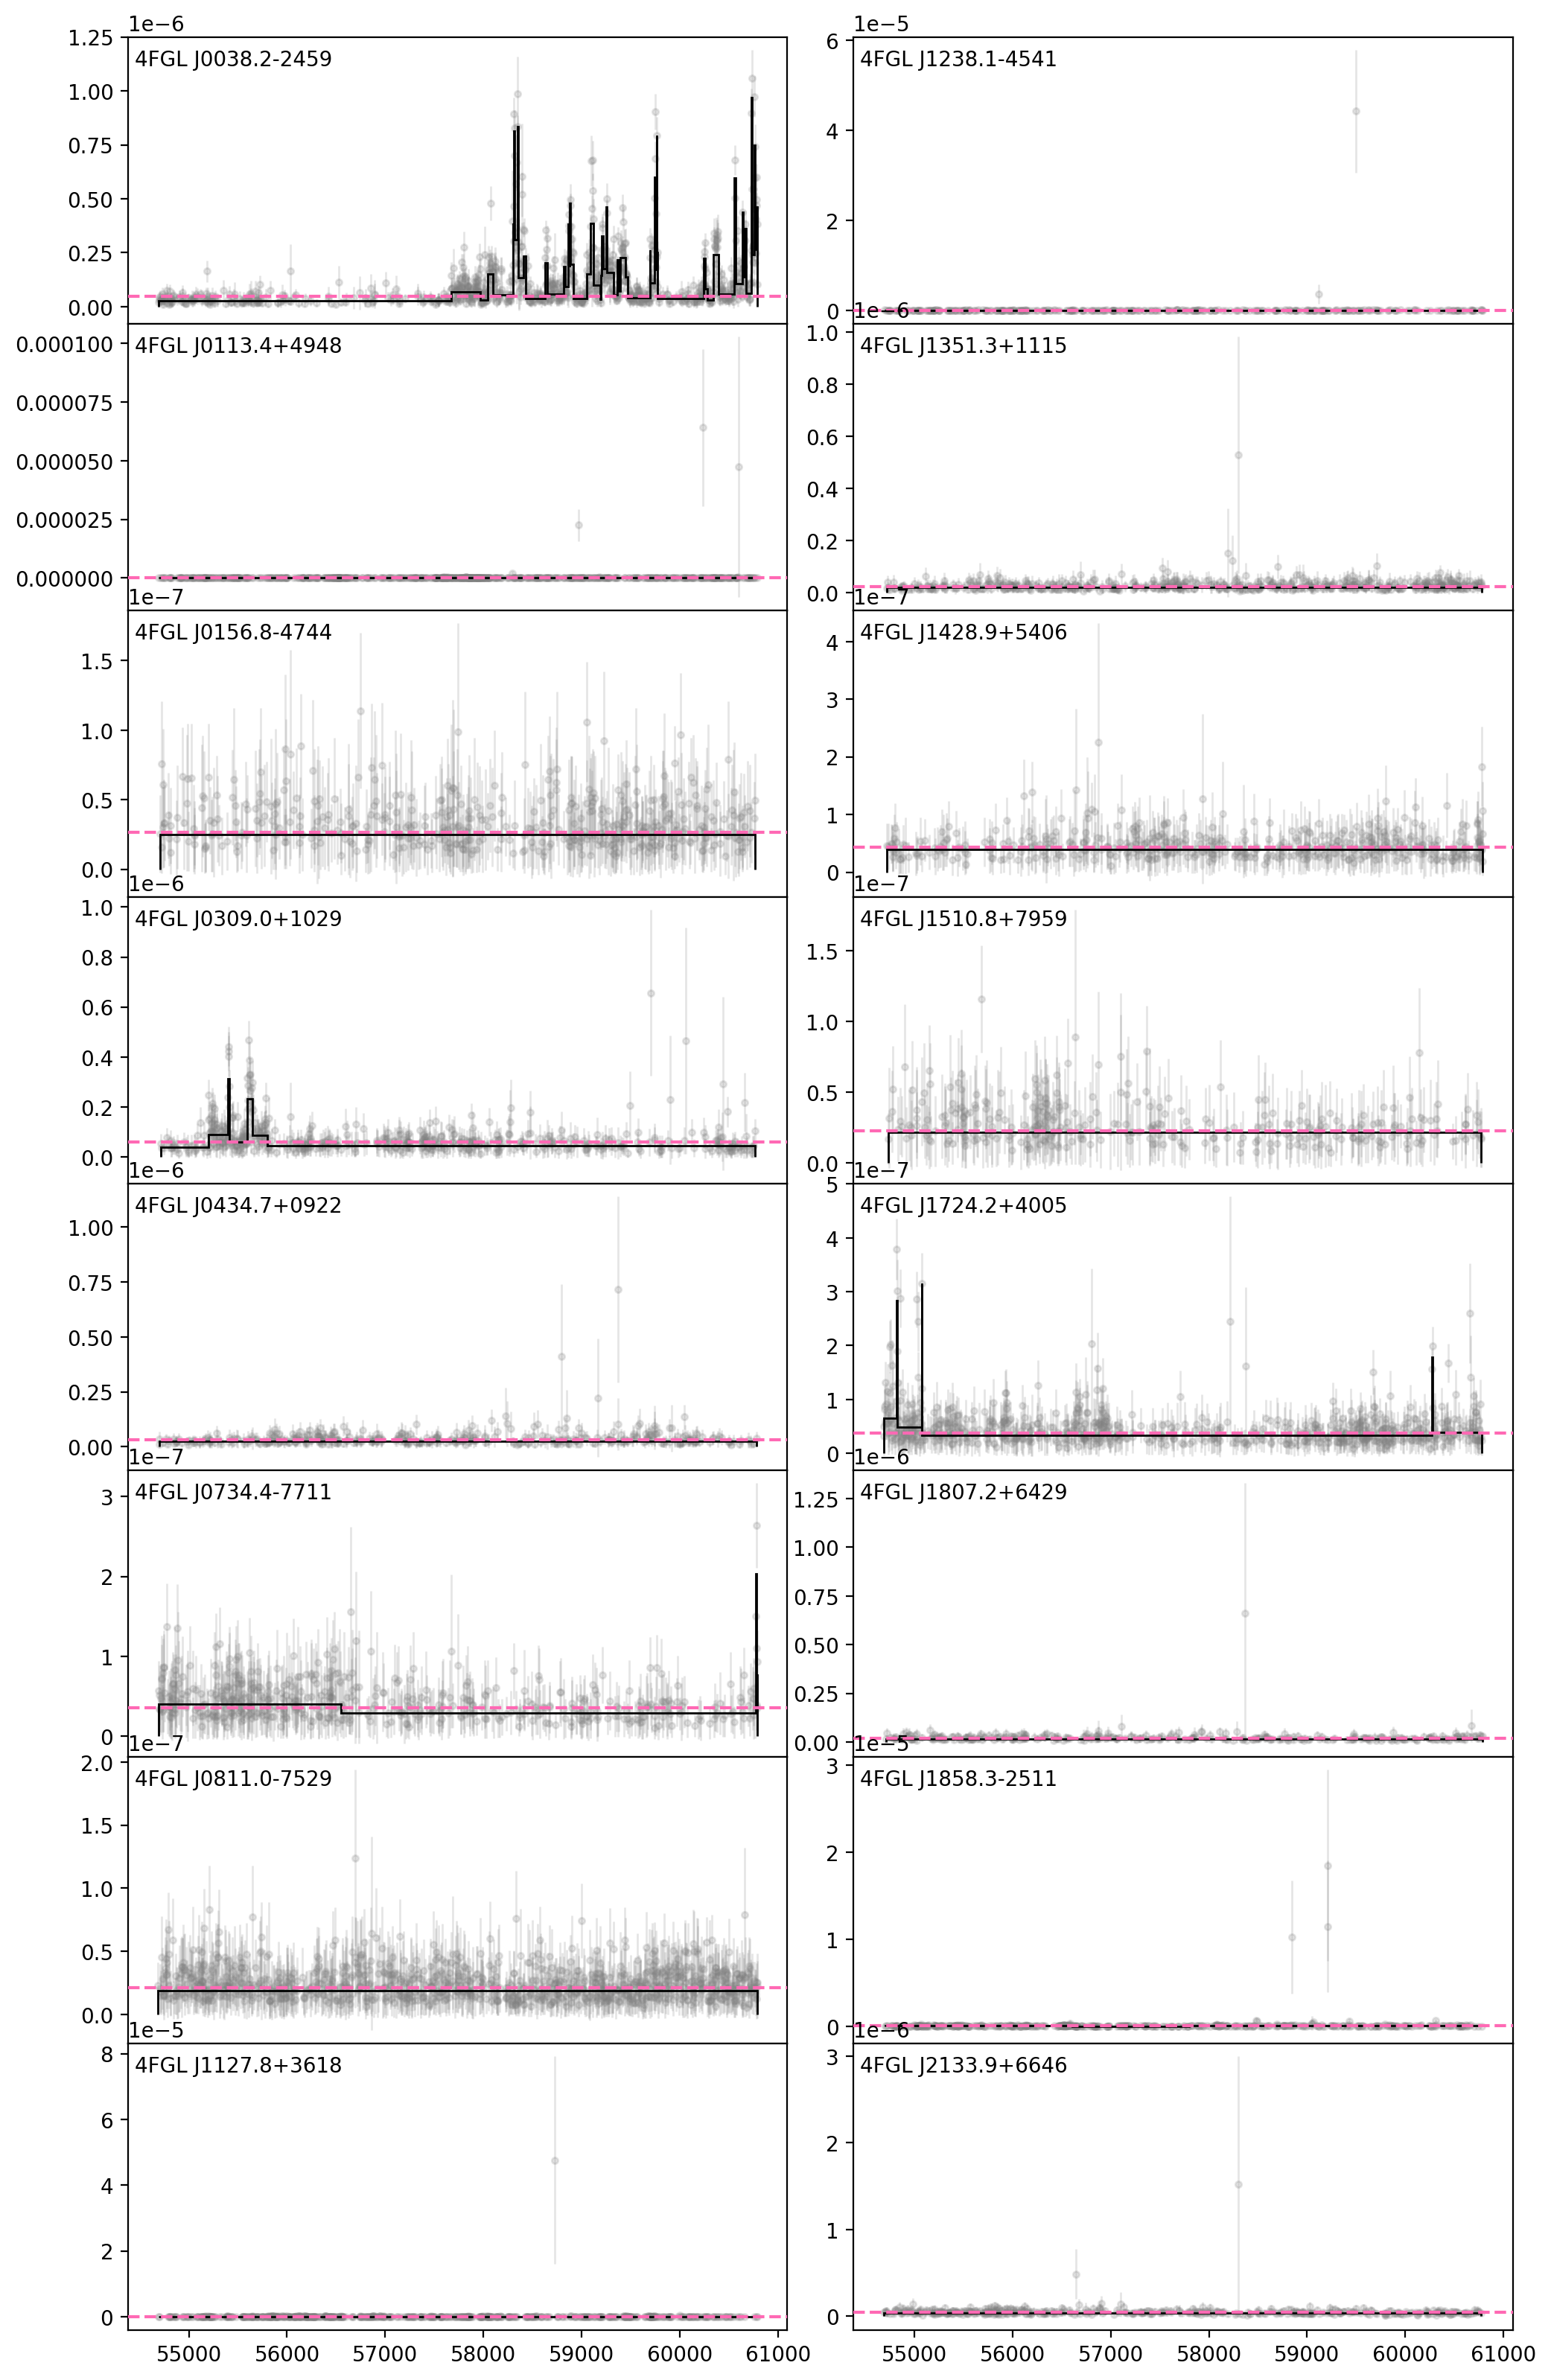

In [8]:
'''
This cell plots the raw, blocked, and quiescent data for each source.
Notice that this time we have also called the function without 
saying it equals anything, just like 2 cells ago, because we also
wrote the plotting function to not return anything

Again, not the best form, but this is more common for functions
that are solely plotting things, because it doesn't really matter if
we "return" the plot or not; it will still show up.
'''

# I'm doing everything but the last source because our list happens to be an odd number
# right now, and I don't want the last source over-plotting on top of other data.

plot_blocks_vs_data(list_of_good_names[:-1])

Text(0.5, 0, 'number of flares in each source')

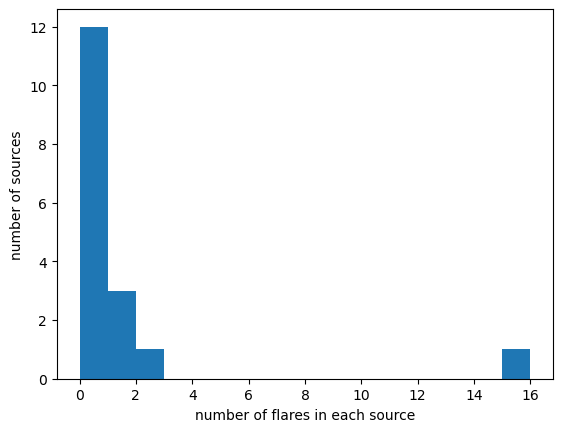

In [13]:
'''
This cell, as it's written below, is entirely from your code 
that you sent me yesterday.
We have changed it since that email, so your notebook cell
will look different. So first, replace everything below with 
what we did yesterday for this cell, instead!
It should include the hop.hop part, etc.

THEN, consider how to turn the major work being done in this cell
- finding flares from the hop.py algorithm, counting them, and
saving them somewhere - into a defined function that takes in
some generally-defined variable(s) and returns the specific things
made by the function itself.

Details on this "homework" are in the Google Doc; have fun!
'''
#figure out if a block from algo is a flare or not, 5x quiesent baseline
quiesent_baseline ={}
list_of_good_flares ={}
num_of_flares_per_source=[]

            

for n in list_of_good_names:
    ids_of_flares=flare_counting(all_blocked_flux[n],quiescent_baseline[n])
    num_of_flares_per_source.append(len(ids_of_flares))
    


    
plt.figure()   
plt.hist(num_of_flares_per_source,bins=range(max(num_of_flares_per_source)+1))
plt.ylabel('number of sources')
plt.xlabel('number of flares in each source')


In [ ]:
'''
This is still just a throwaway cell for guiding us 
in how to save the data later; don't run this!
'''

source= new_flares[0]
table= Table(['''orig.met_detections,orig.flux,orig.flux_error,'''
              good_dets[source],good_flux[source],good_errs[source],
              all_blocked_flux[source],all_edges[source],all_blocked_errs[source]],
             names= ('filtered_mjds','filtered_flux','filtered_errs','blocked_flux','edges','blocked_errs'))